# NASDAQ 100 Trend Classification: Machine Learning's Approach to Identifying Major Turning Points

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import peakutils
from scipy.signal import find_peaks
import seaborn as sns


In [2]:
# Download NASDAQ 100 data
nasdaq_data = yf.download("^NDX", start="2007-01-01", end="2023-08-10")
nasdaq_df = pd.DataFrame(nasdaq_data["Adj Close"])


[*********************100%***********************]  1 of 1 completed


In [3]:
# Smooth the data using a moving average
window_size = 10  
nasdaq_df['Smoothed'] = nasdaq_df['Adj Close'].rolling(window=window_size).mean()


In [4]:
# Fill NaN values in the 'Smoothed' column with the original 'Adj Close' values for continuity
nasdaq_df['Smoothed'].fillna(nasdaq_df['Adj Close'], inplace=True)

              Adj Close     Smoothed
Date                                
2007-01-03  1759.369995  1759.369995
2007-01-04  1792.910034  1792.910034
2007-01-05  1785.300049  1785.300049
2007-01-08  1787.140015  1787.140015
2007-01-09  1795.630005  1795.630005
2007-01-10  1816.150024  1816.150024
2007-01-11  1834.859985  1834.859985
2007-01-12  1844.810059  1844.810059
2007-01-16  1842.439941  1842.439941
2007-01-17  1827.680054  1808.629016
2007-01-18  1793.680054  1812.060022
2007-01-19  1796.810059  1812.450024
2007-01-22  1779.020020  1811.822021
2007-01-23  1773.400024  1810.448022
2007-01-24  1802.630005  1811.148022


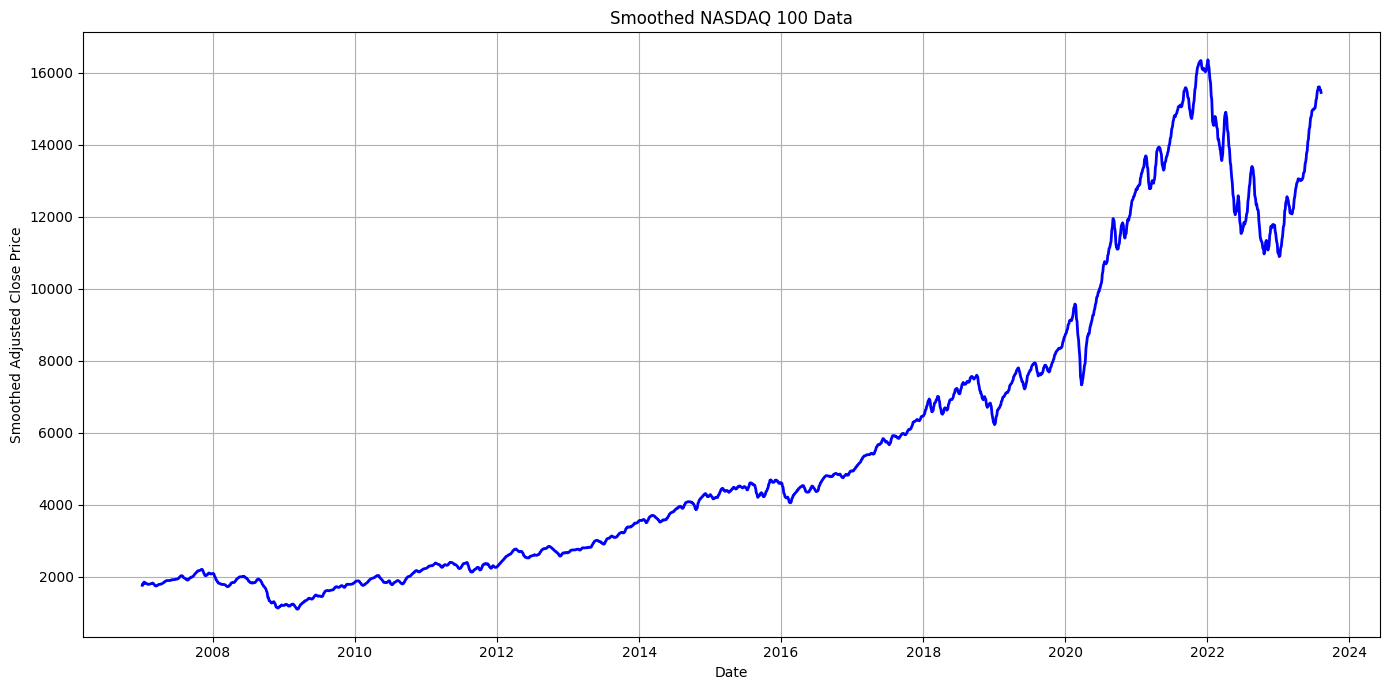

In [5]:
print(nasdaq_df.head(15))

# Plot only the smoothed data for visual inspection
plt.figure(figsize=(14,7))
plt.plot(nasdaq_df.index, nasdaq_df["Smoothed"], label="Smoothed Data", color="blue", linewidth=2)
plt.title("Smoothed NASDAQ 100 Data")
plt.xlabel("Date")
plt.ylabel("Smoothed Adjusted Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


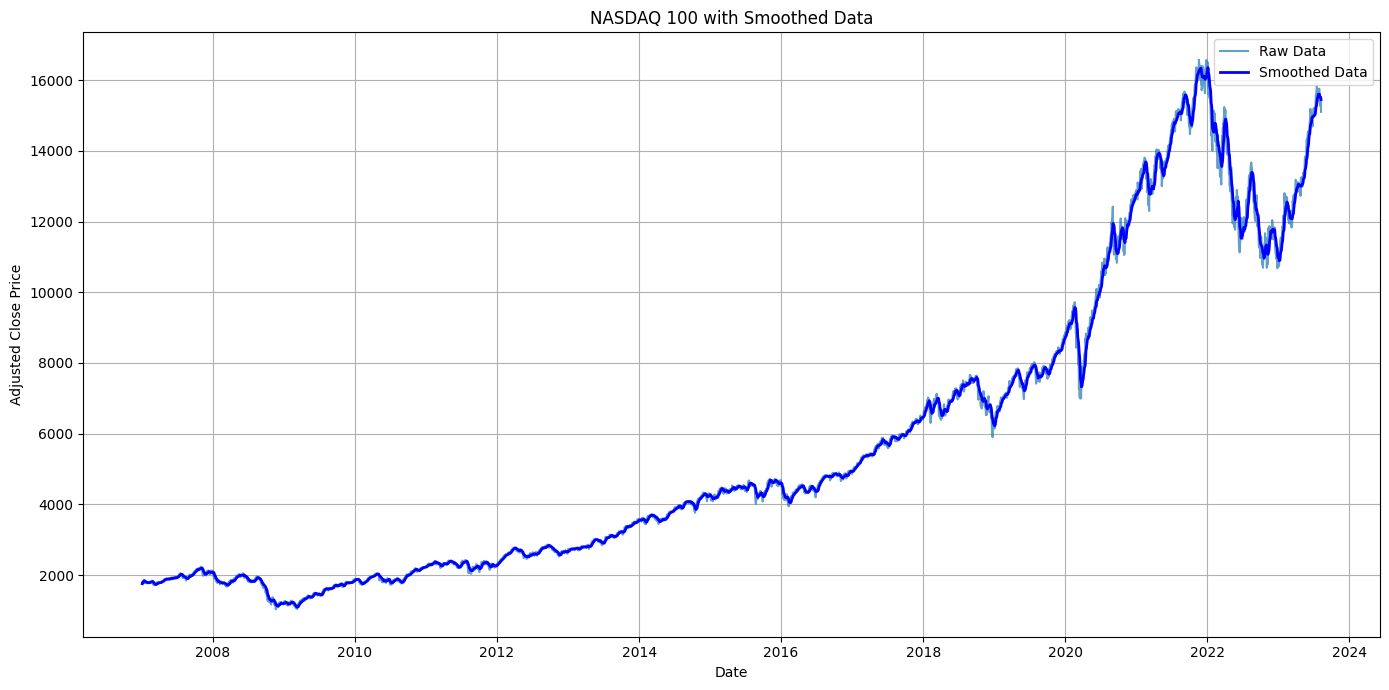

In [6]:
plt.figure(figsize=(14,7))
plt.plot(nasdaq_df.index, nasdaq_df["Adj Close"], label="Raw Data", alpha=0.7)
plt.plot(nasdaq_df.index, nasdaq_df["Smoothed"], label="Smoothed Data", color="blue", linewidth=2)

plt.legend()
plt.title("NASDAQ 100 with Smoothed Data")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Detecting Main Peaks and Valleys

SciPy's find_peaks function offers a prominence parameter, which can be useful to detect significant peaks. The prominence of a peak measures how much a peak stands out from the surrounding baseline. This might be a useful parameter to determine the "main" peaks and valleys.

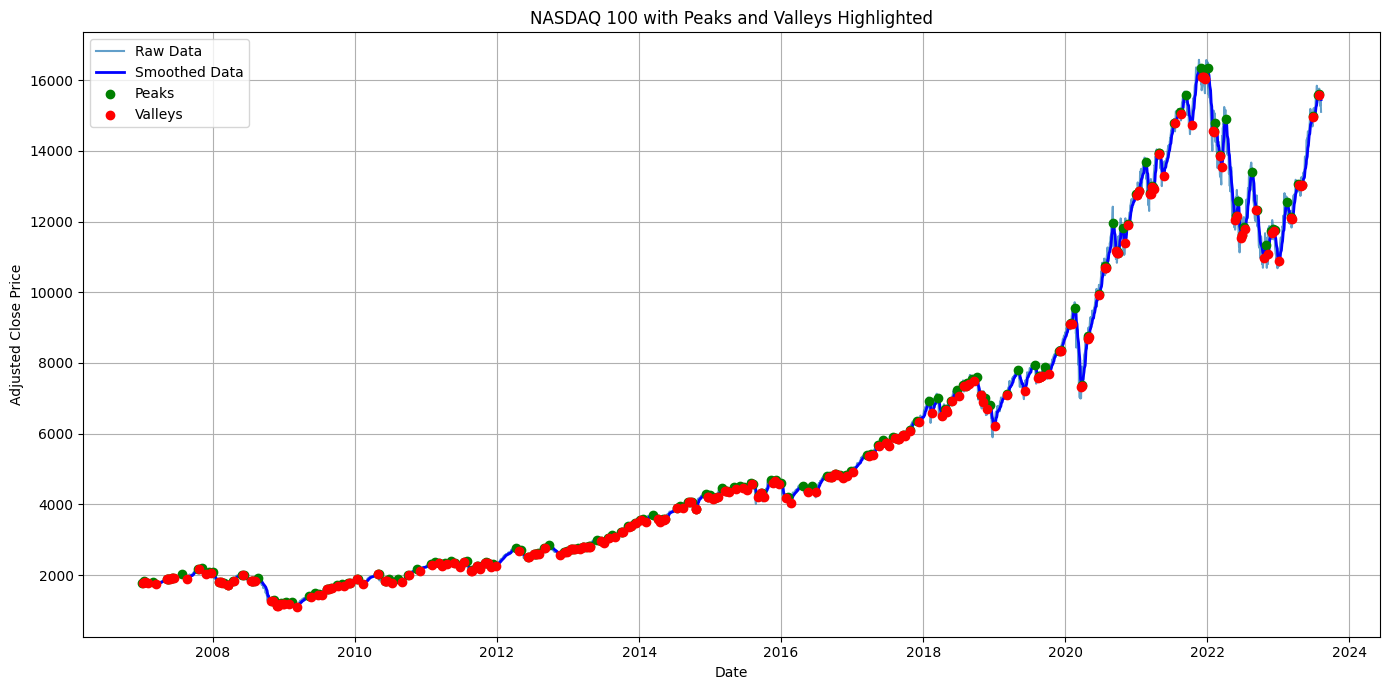

In [7]:
# Detect peaks
peaks, properties = find_peaks(nasdaq_df['Smoothed'].values, prominence=1)

# Detect valleys by inverting the data
inverse_data = -1 * nasdaq_df['Smoothed'].values
valleys, _ = find_peaks(inverse_data, prominence=1)

# Plotting the data with detected peaks and valleys
plt.figure(figsize=(14,7))
plt.plot(nasdaq_df.index, nasdaq_df["Adj Close"], label="Raw Data", alpha=0.7)
plt.plot(nasdaq_df.index, nasdaq_df["Smoothed"], label="Smoothed Data", color="blue", linewidth=2)

peaks_data = nasdaq_df.iloc[peaks]
valleys_data = nasdaq_df.iloc[valleys]
plt.scatter(peaks_data.index, peaks_data["Smoothed"], color='green', label="Peaks", zorder=5)
plt.scatter(valleys_data.index, valleys_data["Smoothed"], color='red', label="Valleys", zorder=5)

plt.legend()
plt.title("NASDAQ 100 with Peaks and Valleys Highlighted")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()




#### Adjusting Prominence Value

The prominence of a peak measures how much a peak stands out from the surrounding baseline, and it's a critical factor in filtering out insignificant peaks or valleys. By adjusting the prominence parameter in the find_peaks function, we can control the sensitivity of the peak detection.

Higher Prominence: Use a larger prominence value to get fewer but more significant peaks. This helps in filtering out smaller peaks which might be just noise.

Lower Prominence: Use a smaller prominence value to detect more peaks, including minor ones. This captures almost all possible peaks but might introduce noise.

To fine-tune the prominence parameter, we can start with a small value and then increase it until we have satisfactory result.

By visual inspection of each plotted graph, the best prominence value is 100.

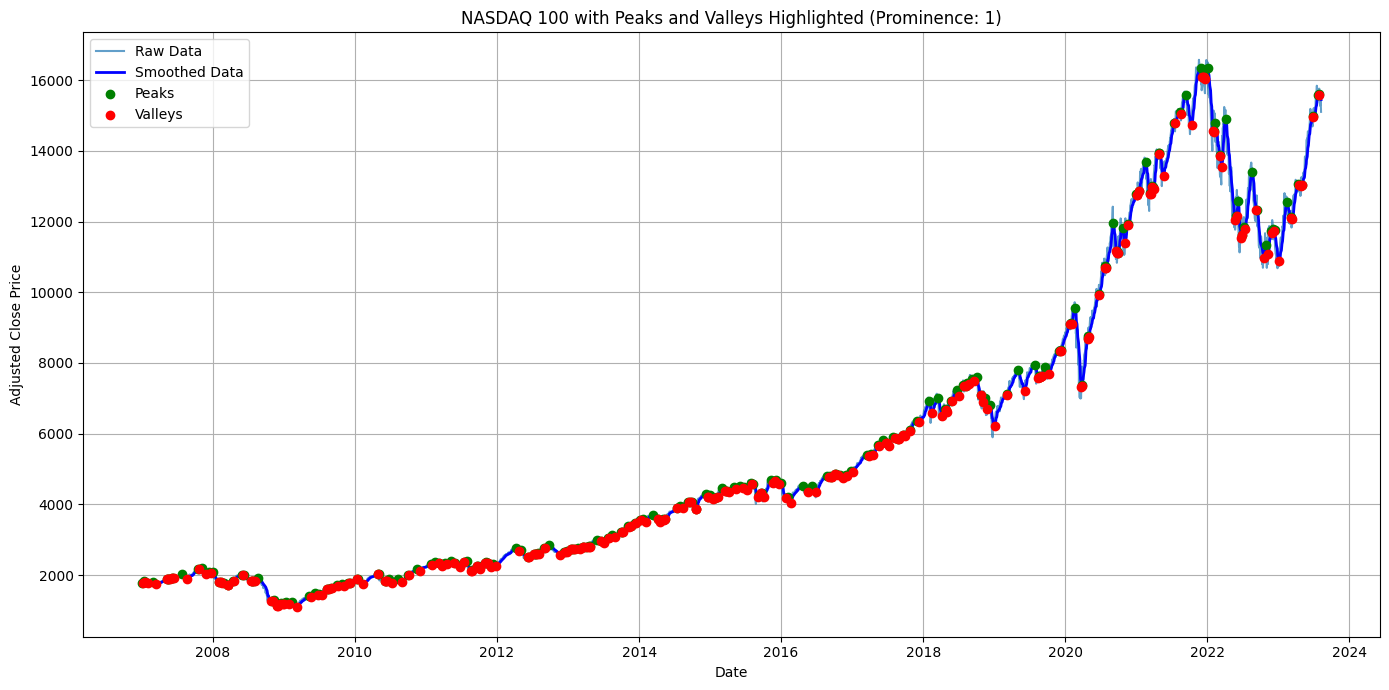

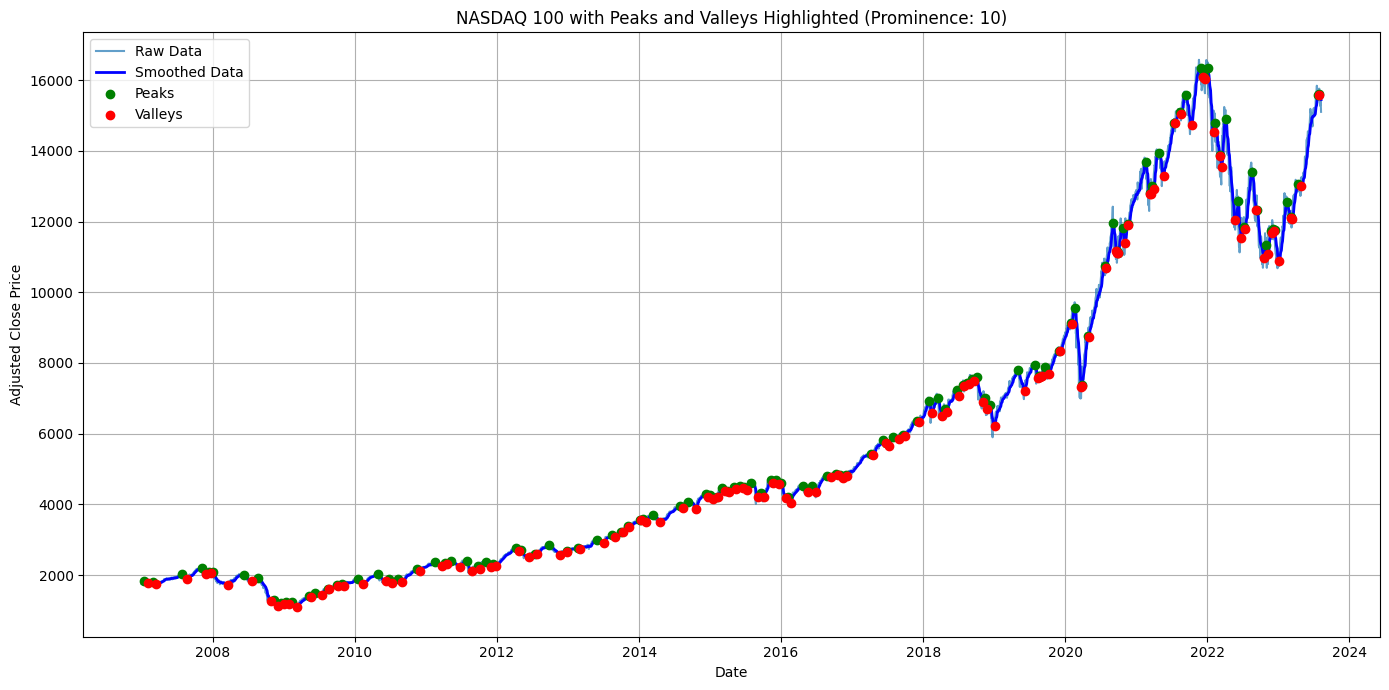

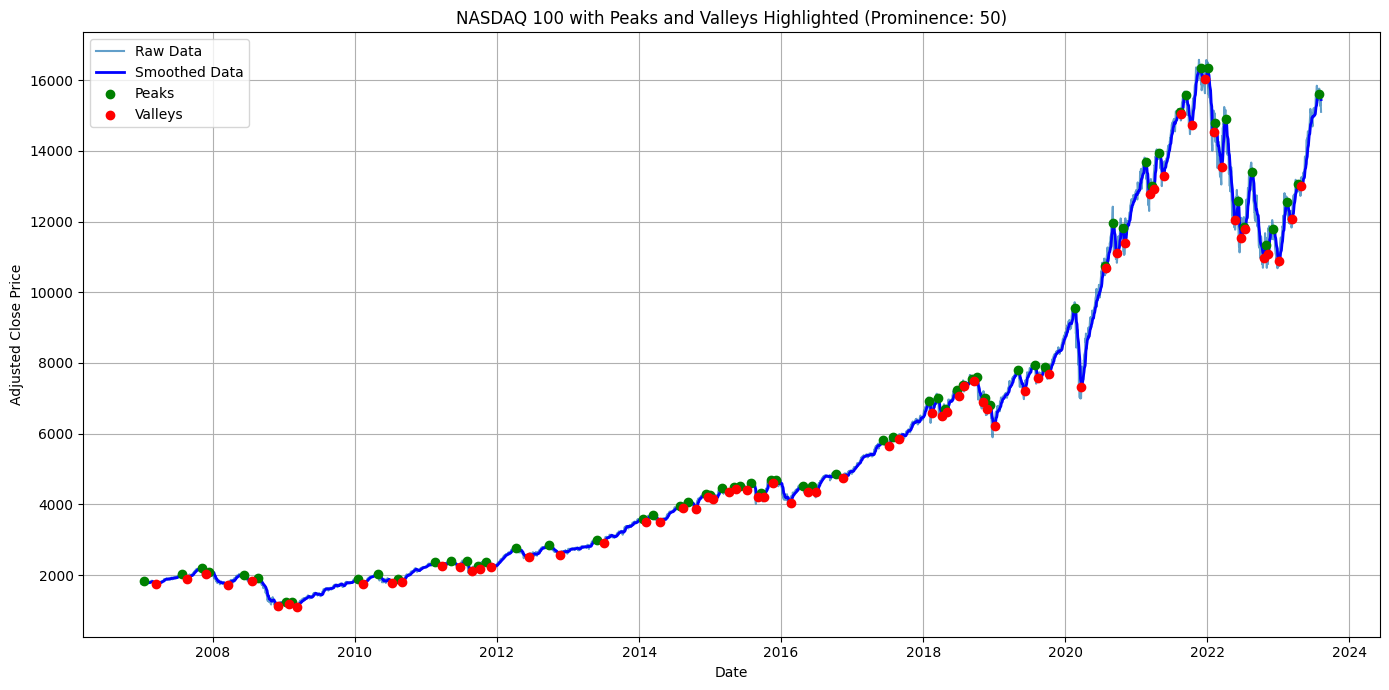

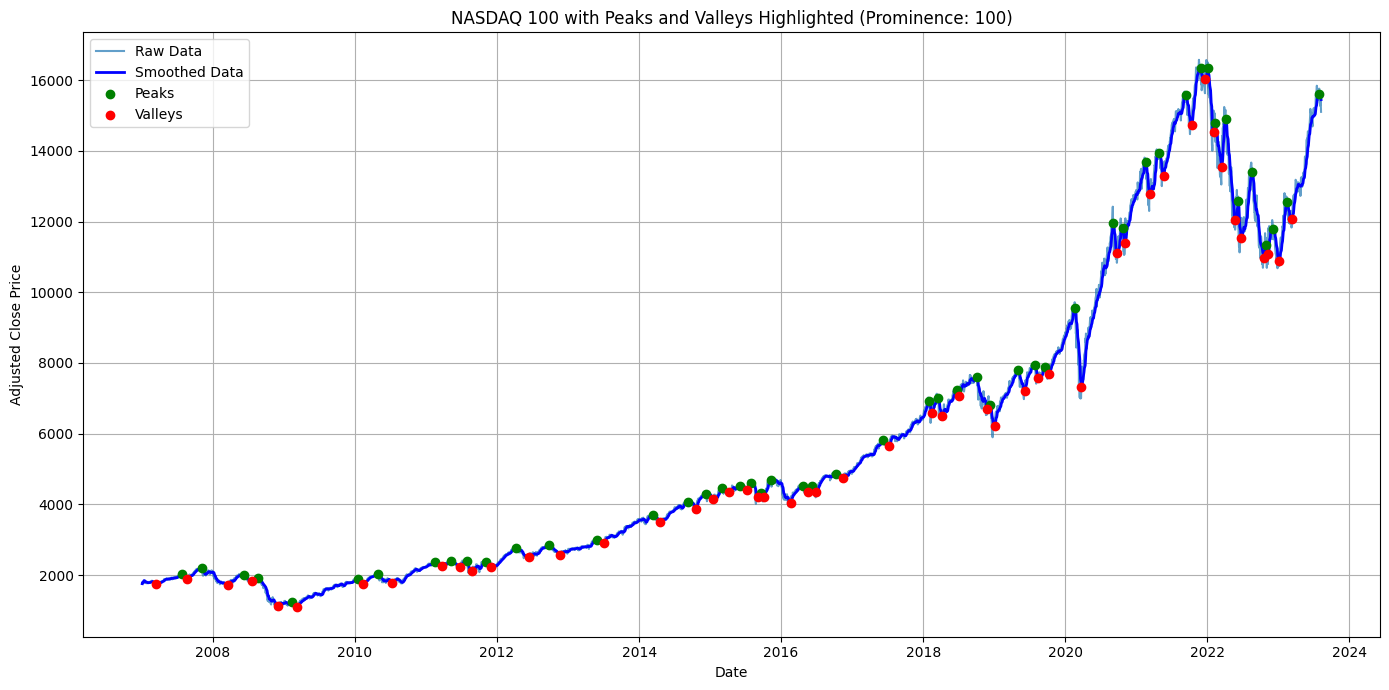

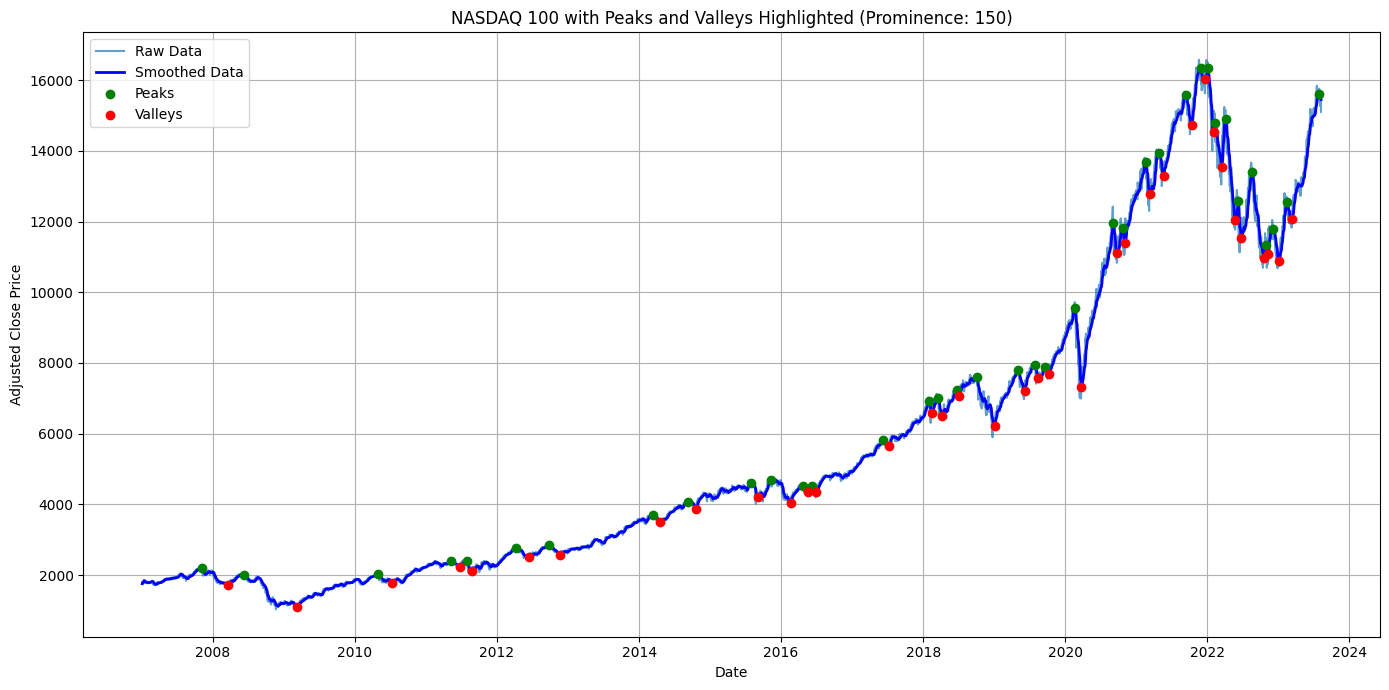

In [8]:
prominence_values = [1, 10, 50, 100, 150]  

for p in prominence_values:
    peaks, _ = find_peaks(nasdaq_df['Smoothed'].values, prominence=p)
    inverse_data = -1 * nasdaq_df['Smoothed'].values
    valleys, _ = find_peaks(inverse_data, prominence=p)
    
    plt.figure(figsize=(14,7))
    plt.plot(nasdaq_df.index, nasdaq_df["Adj Close"], label="Raw Data", alpha=0.7)
    plt.plot(nasdaq_df.index, nasdaq_df["Smoothed"], label="Smoothed Data", color="blue", linewidth=2)
    
    peaks_data = nasdaq_df.iloc[peaks]
    valleys_data = nasdaq_df.iloc[valleys]
    plt.scatter(peaks_data.index, peaks_data["Smoothed"], color='green', label="Peaks", zorder=5)
    plt.scatter(valleys_data.index, valleys_data["Smoothed"], color='red', label="Valleys", zorder=5)
    
    plt.legend()
    plt.title(f"NASDAQ 100 with Peaks and Valleys Highlighted (Prominence: {p})")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


After a visual inspection, we will use a prominence of 100.
We will also add padding around each peak and valley using a simple loop. This involves identifying the main peak or valley and then marking 3 points on each side of it. 

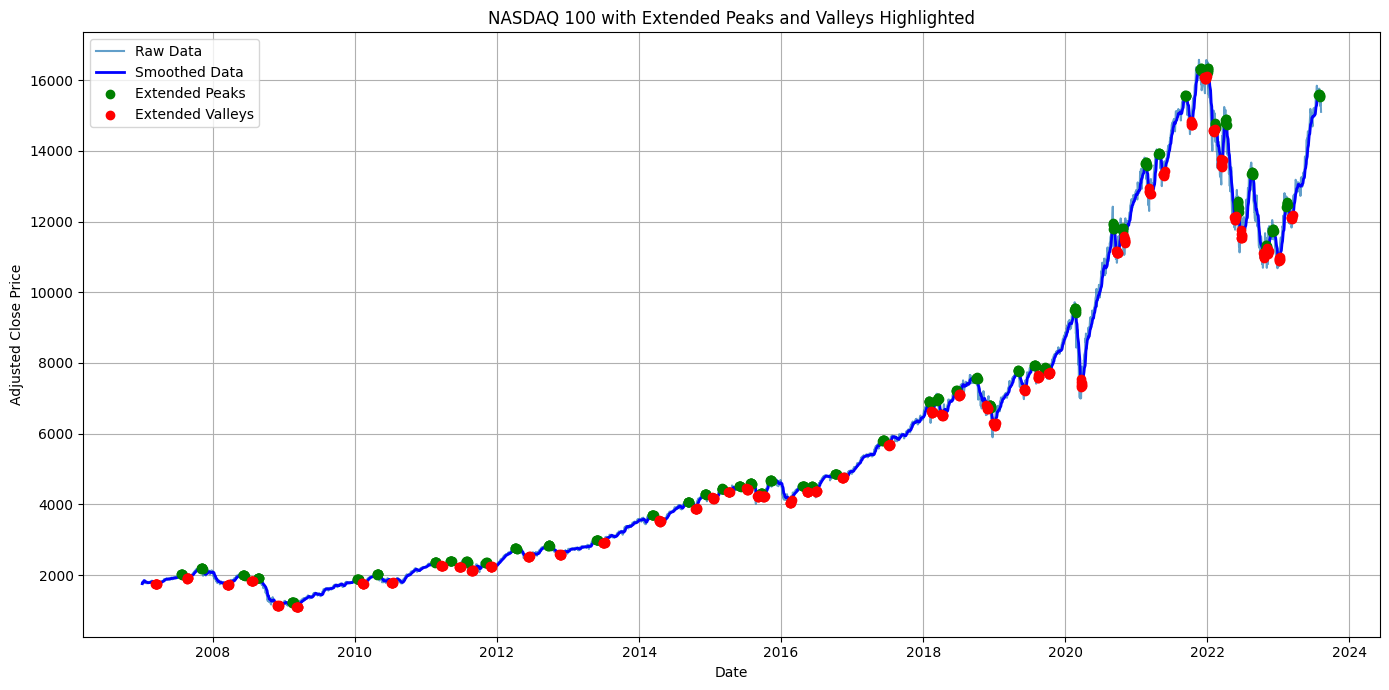

In [9]:
# Identifying peaks and valleys using a prominence of 100
peaks, _ = find_peaks(nasdaq_df['Smoothed'].values, prominence=100)
inverse_data = -1 * nasdaq_df['Smoothed'].values
valleys, _ = find_peaks(inverse_data, prominence=100)

padding = 3  # number of points on each side

# Extend peaks and valleys by adding points to each side
extended_peaks = []
for peak in peaks:
    extended_peaks.extend(list(range(max(0, peak - padding), min(len(nasdaq_df), peak + padding + 1))))

extended_valleys = []
for valley in valleys:
    extended_valleys.extend(list(range(max(0, valley - padding), min(len(nasdaq_df), valley + padding + 1))))

# Plotting the data with extended peaks and valleys
plt.figure(figsize=(14,7))
plt.plot(nasdaq_df.index, nasdaq_df["Adj Close"], label="Raw Data", alpha=0.7)
plt.plot(nasdaq_df.index, nasdaq_df["Smoothed"], label="Smoothed Data", color="blue", linewidth=2)

peaks_data = nasdaq_df.iloc[extended_peaks]
valleys_data = nasdaq_df.iloc[extended_valleys]
plt.scatter(peaks_data.index, peaks_data["Smoothed"], color='green', label="Extended Peaks", zorder=5)
plt.scatter(valleys_data.index, valleys_data["Smoothed"], color='red', label="Extended Valleys", zorder=5)

plt.legend()
plt.title("NASDAQ 100 with Extended Peaks and Valleys Highlighted")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


To prepare the data for classification, we create a new column in the dataframe that captures the labels (extended peaks, extended valleys, and the rest)

In [10]:
# Initialize a new column for labels with default value 2 (the rest)
nasdaq_df['Class'] = 2

# Assign 1 to extended peaks and 3 to extended valleys
nasdaq_df.loc[nasdaq_df.index[extended_peaks], 'Class'] = 1
nasdaq_df.loc[nasdaq_df.index[extended_valleys], 'Class'] = 3


In [11]:
print(nasdaq_df.head())

              Adj Close     Smoothed  Class
Date                                       
2007-01-03  1759.369995  1759.369995      2
2007-01-04  1792.910034  1792.910034      2
2007-01-05  1785.300049  1785.300049      2
2007-01-08  1787.140015  1787.140015      2
2007-01-09  1795.630005  1795.630005      2


In [12]:
nasdaq_df.to_csv('nasdaq_data.csv')


In [13]:
print(nasdaq_df.isnull().sum())


Adj Close    0
Smoothed     0
Class        0
dtype: int64


In [14]:
# Display basic statistics
print(nasdaq_df.describe())


          Adj Close      Smoothed        Class
count   4179.000000   4179.000000  4179.000000
mean    5655.097264   5640.539601     2.000718
std     4199.289001   4187.264697     0.408443
min     1036.510010   1093.320996     1.000000
25%     2221.080078   2226.492517     2.000000
50%     4293.229980   4278.121973     2.000000
75%     7610.500000   7601.486475     2.000000
max    16573.339844  16355.247949     3.000000


In [15]:
print(nasdaq_df['Class'].value_counts())


Class
2    3482
3     350
1     347
Name: count, dtype: int64


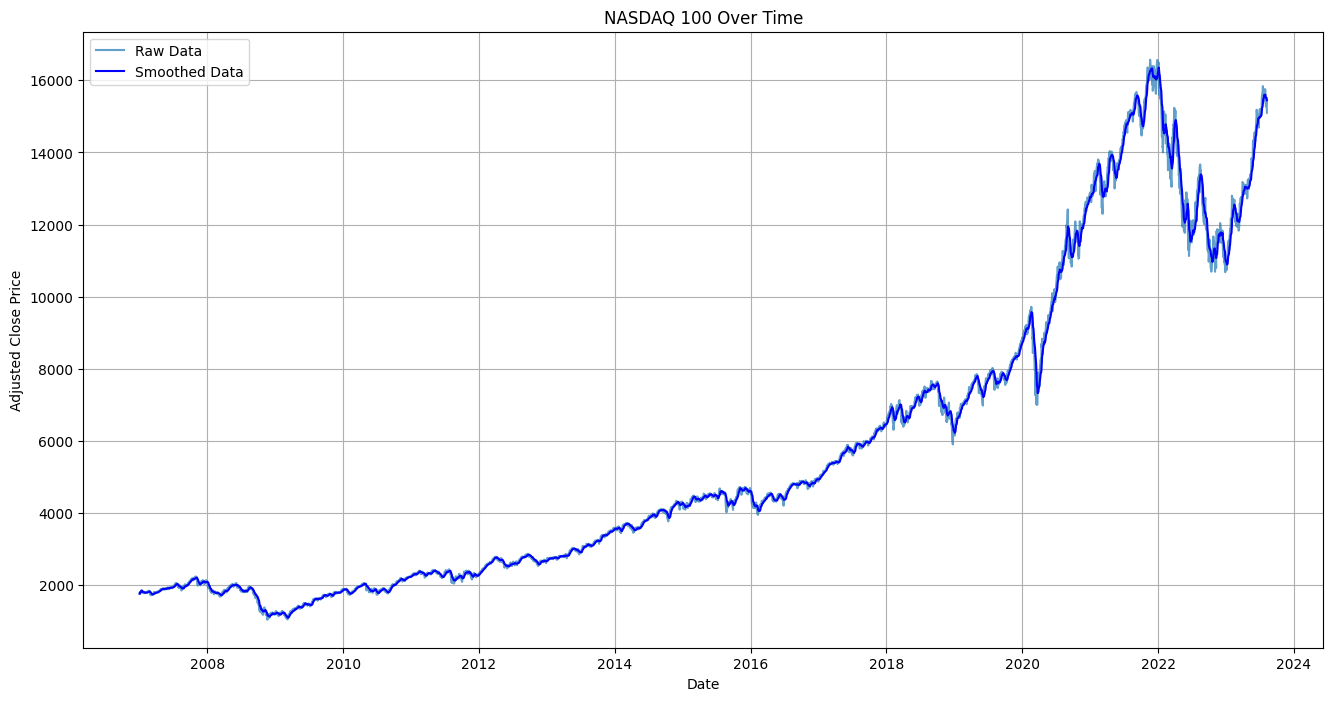

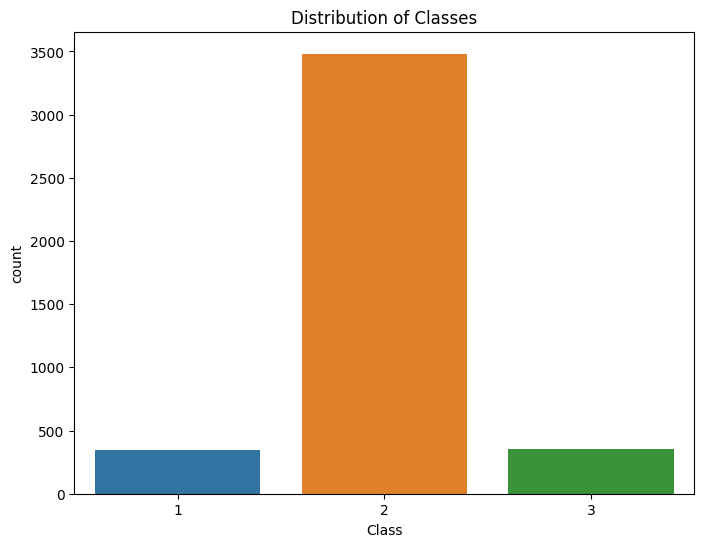

In [16]:
# Plotting the Adjusted Close and Smoothed data
plt.figure(figsize=(16, 8))
plt.plot(nasdaq_df.index, nasdaq_df["Adj Close"], label="Raw Data", alpha=0.7)
plt.plot(nasdaq_df.index, nasdaq_df["Smoothed"], label="Smoothed Data", color="blue")
plt.title("NASDAQ 100 Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(True)
plt.show()

# Plotting the distribution of classes
plt.figure(figsize=(8, 6))
sns.countplot(x="Class", data=nasdaq_df)
plt.title("Distribution of Classes")
plt.show()
